### Import Pre-requisites

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV


### Read MIMIC-IV dataset

In [2]:
df_icu = pd.read_csv('../mimic_iv_data/icustays.csv.gz', compression='gzip')
df_patients = pd.read_csv('../mimic_iv_data/patients.csv.gz', compression='gzip')
df_chart_events = pd.read_csv('../mimic_iv_data/chartevents.csv.gz', compression='gzip')
df_d_items = pd.read_csv('../mimic_iv_data/d_items.csv.gz', compression='gzip')

/var/folders/qs/0m6hz3wj0fd1045_rghhzxtr0000gp/T/ipykernel_56233/681484393.py:3: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chart_events = pd.read_csv('../mimic_iv_data/chartevents.csv.gz', compression='gzip')


In [3]:
df_lab_events = pd.read_csv('../mimic_iv_data/labevents.csv.gz', compression='gzip')
df_d_labitems = pd.read_csv('../mimic_iv_data/d_labitems.csv.gz', compression='gzip')

/var/folders/qs/0m6hz3wj0fd1045_rghhzxtr0000gp/T/ipykernel_56233/1662893995.py:1: DtypeWarning: Columns (7,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lab_events = pd.read_csv('../mimic_iv_data/labevents.csv.gz', compression='gzip')


### Cleanup and Pre-process data

- Get age, gender from the patients table

In [4]:
df_patients.info()
df_patients_f = df_patients

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382278 entries, 0 to 382277
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         382278 non-null  int64 
 1   gender             382278 non-null  object
 2   anchor_age         382278 non-null  int64 
 3   anchor_year        382278 non-null  int64 
 4   anchor_year_group  382278 non-null  object
 5   dod                9509 non-null    object
dtypes: int64(3), object(3)
memory usage: 17.5+ MB


In [5]:
# Select subject_id, gender, anchor_age, dod
selected_columns = ['subject_id', 'gender', 'anchor_age', 'dod']
df_patients_f = df_patients.loc[:, selected_columns]
df_patients_f.head()

,subject_id,gender,anchor_age,dod
0,10000048,F,23,NaN
1,10002723,F,0,NaN
2,10003939,M,0,NaN
3,10004222,M,0,NaN
4,10005325,F,0,NaN


In [6]:
# Replace dod with disceased, NaN with 0, and not NaN with 1
df_patients_f['dod'] = df_patients_f['dod'].notna().astype(int)
# Rename the columns
df_patients_f.rename(columns={'dod': 'deceased'}, inplace=True)
# Change gender M to 0 and F to 1
df_patients_f['gender'] = df_patients_f['gender'].replace({'M': 0, 'F': 1})
df_patients_f.head()

/var/folders/qs/0m6hz3wj0fd1045_rghhzxtr0000gp/T/ipykernel_56233/982517482.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_patients_f['gender'] = df_patients_f['gender'].replace({'M': 0, 'F': 1})


,subject_id,gender,anchor_age,deceased
0,10000048,1,23,0
1,10002723,1,0,0
2,10003939,0,0,0
3,10004222,0,0,0
4,10005325,1,0,0


- Plot the age histogram

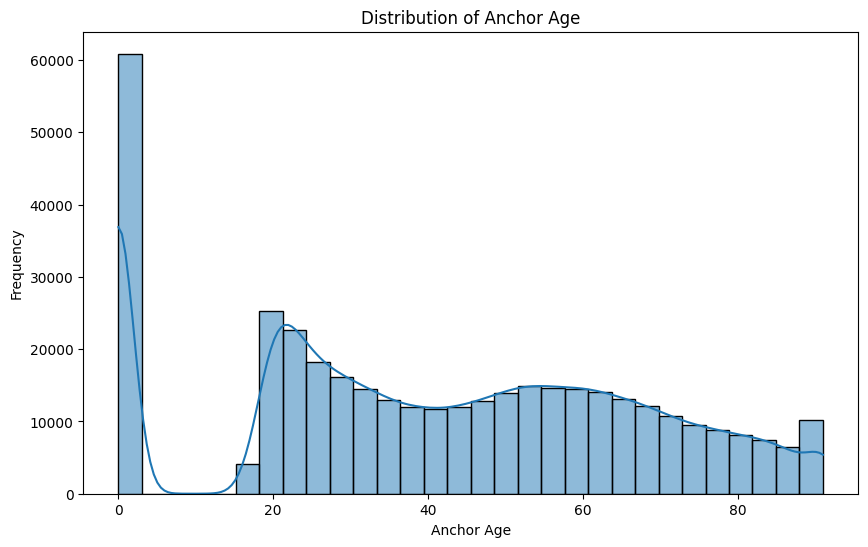

In [7]:
# Create histogram of anchor_age
plt.figure(figsize=(10, 6))
sns.histplot(df_patients_f['anchor_age'], bins=30, kde=True)
plt.title('Distribution of Anchor Age')
plt.xlabel('Anchor Age')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Include only patients with anchor_age > 0
df_patients_f = df_patients_f[df_patients_f['anchor_age'] > 0]

- Find number of patients who are deceased

In [9]:
# Find number of patients who are deceased
deceased_count = df_patients_f['deceased'].value_counts()
print(deceased_count)

deceased
0    312110
1      9296
Name: count, dtype: int64


- Find the itemids for the chart events (Heart Rate, Blood Pressure, SpO2, Temperature)

In [10]:
df_d_items.info()
df_d_items.head()
# Find item for Heart Rate, Blood Pressure, SpO2, Temperature
df_d_items[df_d_items['label'].str.contains('Heart Rate', na=False)].head()
df_d_items[df_d_items['label'].str.contains('Blood Pressure', na=False)].head()
df_d_items[df_d_items['label'].str.contains('SpO2', na=False)].head()
df_d_items[df_d_items['label'].str.contains('Temperature', na=False)].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemid           3861 non-null   int64  
 1   label            3861 non-null   object 
 2   abbreviation     3861 non-null   object 
 3   linksto          3861 non-null   object 
 4   category         3861 non-null   object 
 5   unitname         979 non-null    object 
 6   param_type       3861 non-null   object 
 7   lownormalvalue   19 non-null     float64
 8   highnormalvalue  22 non-null     float64
dtypes: float64(2), int64(1), object(6)
memory usage: 271.6+ KB


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
220,223761,Temperature Fahrenheit,Temperature F,chartevents,Routine Vital Signs,°F,Numeric,NaN,NaN
221,223762,Temperature Celsius,Temperature C,chartevents,Routine Vital Signs,°C,Numeric,NaN,NaN
368,224027,Skin Temperature,Skin Temp,chartevents,Skin - Assessment,NaN,Text,NaN,NaN
589,224642,Temperature Site,Temp Site,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN
1405,226329,Blood Temperature CCO (C),Blood Temp CCO (C),chartevents,Routine Vital Signs,°C,Numeric,NaN,NaN


- Get only the critical vitals from the chart events

In [11]:
chart_events_list = [220045, 220050, 220051, 226253, 223761, 220210, 
                    220179, 220180, 220181, 223762, 220277, 223835, 224700]
for itemid in chart_events_list:
    print(f'{itemid}: {df_d_items[df_d_items["itemid"] == itemid]["label"].values[0]}')

220045: Heart Rate
220050: Arterial Blood Pressure systolic
220051: Arterial Blood Pressure diastolic
226253: SpO2 Desat Limit
223761: Temperature Fahrenheit
220210: Respiratory Rate
220179: Non Invasive Blood Pressure systolic
220180: Non Invasive Blood Pressure diastolic
220181: Non Invasive Blood Pressure mean
223762: Temperature Celsius
220277: O2 saturation pulseoxymetry
223835: Inspired O2 Fraction
224700: Total PEEP Level


- Filter the chart events for only the desired events

In [12]:

df_chart_events_f = df_chart_events[df_chart_events['itemid'].isin(chart_events_list)]
# Remove duplicate items in itemid
df_chart_events_f.drop_duplicates(subset=['subject_id', 'itemid'], inplace=True)
df_chart_events_f.head()


/var/folders/qs/0m6hz3wj0fd1045_rghhzxtr0000gp/T/ipykernel_56233/4228789061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chart_events_f.drop_duplicates(subset=['subject_id', 'itemid'], inplace=True)


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
12,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220179,152.0,152.0,mmHg,0
13,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220180,97.0,97.0,mmHg,0
14,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220181,110.0,110.0,mmHg,0
15,10003700,28623837,30600691,2165-04-24 05:30:00,2165-04-24 05:37:00,220045,65.0,65.0,bpm,0
16,10003700,28623837,30600691,2165-04-24 05:30:00,2165-04-24 05:37:00,220210,14.0,14.0,insp/min,0


In [13]:
# Select the relevant columns
selected_columns = ['subject_id', 'hadm_id', 'stay_id', 'itemid', 'value']
df_chart_events_f = df_chart_events_f.loc[:, selected_columns]
df_chart_events_f.head()

,subject_id,hadm_id,stay_id,itemid,value
12,10003700,28623837,30600691,220179,152.0
13,10003700,28623837,30600691,220180,97.0
14,10003700,28623837,30600691,220181,110.0
15,10003700,28623837,30600691,220045,65.0
16,10003700,28623837,30600691,220210,14.0


- Pivot and create new columns for the chart event list

In [14]:
# Pivot on itemid
df_chart_events_pivot = df_chart_events_f.pivot(index='subject_id', columns='itemid', values='value').reset_index()
# Rename the columns
chart_events_list_str = [str(itemid) for itemid in chart_events_list]
df_chart_events_pivot.columns = ['subject_id'] + chart_events_list_str
df_chart_events_pivot.dropna(axis=0, inplace=True)
df_chart_events_pivot.head()


,subject_id,220045,220050,220051,226253,223761,220210,220179,220180,220181,223762,220277,223835,224700
5,10002013,80,134,75,104,70,77,14,100,97.2,37.2,100,5,85
31,10005348,84.0,118.0,56.0,109.0,52.0,67.0,15.0,100.0,97.7,35.1,100.0,5.9,85.0
33,10005817,80,126,51,118,40,57,15,100,98.3,36.2,100,6,85
36,10006053,114,130,58,110,62,74,32,100,94.6,34.7,80,13,88
45,10007818,97.0,85.0,47.0,63.0,41.0,46.0,28.0,99.0,98.1,36.1,100.0,6.0,88.0


- Find the critical lab events

In [15]:
lab_events_list = [50813, 50882, 50912, 50809, 51221]
for itemid in lab_events_list:
    print(f'{itemid}: {df_d_labitems[df_d_labitems["itemid"] == itemid]["label"].values[0]}')

50813: Lactate
50882: Bicarbonate
50912: Creatinine
50809: Glucose
51221: Hematocrit


- Filter the lab events table

In [16]:
df_lab_events_f = df_lab_events[df_lab_events['itemid'].isin(lab_events_list)]
# Remove duplicate items in itemid
df_lab_events_f.drop_duplicates(subset=['subject_id', 'itemid'], inplace=True)
df_lab_events_f.head()


/var/folders/qs/0m6hz3wj0fd1045_rghhzxtr0000gp/T/ipykernel_56233/190256166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lab_events_f.drop_duplicates(subset=['subject_id', 'itemid'], inplace=True)


,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
8,688,10000048,NaN,82729055,50882,2126-11-22 20:45:00,2126-11-22 21:32:00,26,26.0,mEq/L,22.0,32.0,NaN,STAT,NaN
11,691,10000048,NaN,82729055,50912,2126-11-22 20:45:00,2126-11-22 21:32:00,0.7,0.7,mg/dL,0.4,1.1,NaN,STAT,NaN
19,700,10000048,NaN,90050443,51221,2126-11-22 20:45:00,2126-11-22 21:32:00,38.2,38.2,%,36.0,48.0,NaN,STAT,NaN
37,2078,10000473,NaN,46889666,50882,2138-03-15 22:37:00,2138-03-15 23:56:00,25,25.0,mEq/L,22.0,32.0,NaN,STAT,NaN
40,2081,10000473,NaN,46889666,50912,2138-03-15 22:37:00,2138-03-15 23:56:00,1.2,1.2,mg/dL,0.5,1.2,NaN,STAT,NaN


In [17]:
# Select the relevant columns
selected_columns = ['subject_id', 'itemid', 'value']
df_lab_events_f = df_lab_events_f.loc[:, selected_columns]
df_lab_events_f.head()

,subject_id,itemid,value
8,10000048,50882,26
11,10000048,50912,0.7
19,10000048,51221,38.2
37,10000473,50882,25
40,10000473,50912,1.2


In [18]:
# Pivot on itemid
df_lab_events_pivot = df_lab_events_f.pivot(index='subject_id', columns='itemid', values='value').reset_index()
lab_events_list_str = [str(itemid) for itemid in lab_events_list]
df_lab_events_pivot.columns = ['subject_id'] + lab_events_list_str
df_lab_events_pivot.dropna(axis=0, inplace=True)
df_lab_events_pivot.head()

,subject_id,50813,50882,50912,50809,51221
20,10000826,125,2.3,26,0.4,40.3
51,10001884,91,0.8,29,0.8,39.9
54,10002013,332,2.3,26,0.9,33.1
61,10002223,106,1.0,26,0.9,38.6
65,10002428,132,2.2,29,0.8,35.2


- Merge the chart, patients and lab events table

In [19]:
# Merge with patients
df_merged = df_chart_events_pivot.merge(df_patients_f, how='inner', on='subject_id')
df_merged = df_merged.merge(df_lab_events_pivot, how='inner', on='subject_id')
df_merged.head()

,subject_id,220045,220050,220051,226253,223761,220210,220179,220180,220181,...,223835,224700,gender,anchor_age,deceased,50813,50882,50912,50809,51221
0,10002013,80,134,75,104,70,77,14,100,97.2,...,5,85,1,53,0,332,2.3,26,0.9,33.1
1,10005348,84.0,118.0,56.0,109.0,52.0,67.0,15.0,100.0,97.7,...,5.9,85.0,0,76,0,89,0.6,29,1.1,38.3
2,10005817,80,126,51,118,40,57,15,100,98.3,...,6,85,0,66,1,226,1.0,32,1.0,25.7
3,10006053,114,130,58,110,62,74,32,100,94.6,...,13,88,0,52,1,179,0.9,22,1.7,24.0
4,10007818,97.0,85.0,47.0,63.0,41.0,46.0,28.0,99.0,98.1,...,6.0,88.0,0,69,1,154,7.3,21,2.0,35.6


- Create the label(target) and the features

In [20]:

# Save the merged dataframe
df_merged.to_csv('merged_data.csv', index=False)


In [21]:
import pandas as pd

# Read the merged dataframe
df_merged = pd.read_csv('merged_data.csv')
target = df_merged['deceased']
X = df_merged.drop(columns=['subject_id', 'deceased'])
y = target


### Model training

In [22]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 3520 samples.
Testing set has 880 samples.


#### Machine Learning Models

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Regression models for comparison
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0),]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))
    print("R^2 Score:", r2_score(y_test, y_test_preds))
    print("Mean Squared Error:", mean_squared_error(y_test, y_test_preds))
    #print(classification_report(y_test, (y_test_preds >= 0.5).astype(int)))

    # Confusion matrix
    y_test_preds = (y_test_preds >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_test_preds)
    print(cm)

SGDRegressor done.
R^2 Score: 0.08273955649574727
Mean Squared Error: 0.16390226481133907
[[675   0]
 [202   3]]
GradientBoostingRegressor done.
R^2 Score: 0.18919636139670715
Mean Squared Error: 0.14487984696762737
[[636  39]
 [155  50]]
LinearRegression done.
R^2 Score: 0.15670936580229355
Mean Squared Error: 0.15068484182219477
[[651  24]
 [172  33]]
KNeighborsRegressor done.
R^2 Score: -0.036603432700993865
Mean Squared Error: 0.18522727272727277
[[632  43]
 [176  29]]
RandomForestRegressor done.
R^2 Score: 0.17066637759710923
Mean Squared Error: 0.1481909090909091
[[614  61]
 [151  54]]


Text(0.5, 1.0, 'Comparison of Regression Models')

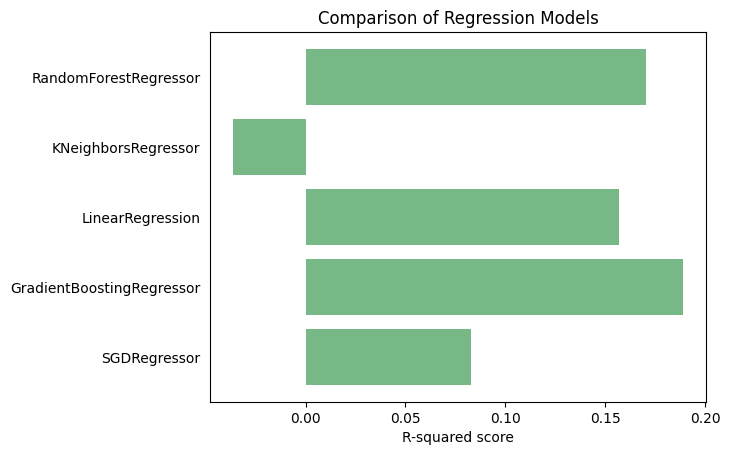

In [24]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [25]:
# GradientBoostingRegressor will be used as the deceased prediction model
reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.189196


#### Model finetuning

In [26]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    target,
                                                    test_size = .20,
                                                    random_state = 42)

# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['squared_error', 'absolute_error']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.16494305884071675
GradientBoostingRegressor(n_estimators=200)


In [27]:
#reg_model = GradientBoostingRegressor(n_estimators = 200, max_depth=4, random_state=0)
#reg_model.fit(X_train, y_train)
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.179233


- Print the new confusion matrix after optimizing

In [28]:
y_test_preds = (y_test_preds >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_test_preds)
print(cm)

[[635  40]
 [143  62]]


In [29]:

print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by -0.0100


### Create a Deep Learning Model

- Convert the data frame to tensors

In [30]:
# Convert df_merged to a tensor
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score

# Convert the data to PyTorch tensors
X = df_merged.drop(columns=['subject_id', 'deceased'])
y = df_merged['deceased']

# Convert all of the columns to float32
X = X.astype(np.float32)
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device='mps')
print(X_tensor.shape)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device='mps')
print(y_tensor.shape)


torch.Size([4400, 20])
torch.Size([4400])


- Normalize the data

In [31]:
# Normalize the data
X_tensor = (X_tensor - X_tensor.mean(dim=0)) / X_tensor.std(dim=0)
y_tensor = (y_tensor - y_tensor.mean(dim=0)) / y_tensor.std(dim=0)
 

- Split the date into training and test data

In [32]:
# Split the data into training (80%) and testing sets (20%)
n_samples = X_tensor.shape[0]
n_val = int(n_samples * 0.2)
n_train = n_samples - n_val
train_data = X_tensor[:n_train].to(device='mps')
val_data = X_tensor[n_train:].to(device='mps')
train_labels = y_tensor[:n_train].to(device='mps')
val_labels = y_tensor[n_train:].to(device='mps')

- Create a binary classification model

In [33]:
# Create a binary classification model
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

- Train and evaluate the model

In [34]:
# Train the model
input_size = X_tensor.shape[1]
model = BinaryClassificationModel(input_size).to(device='mps')
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs.squeeze(), train_labels)
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
with torch.inference_mode():
    model.eval()

    val_outputs = model(val_data)
    val_loss = criterion(val_outputs.squeeze(), val_labels)

    # Convert predictions to binary (0 or 1) for classification metrics
    val_preds = (val_outputs.squeeze() >= 0.5).float()
    
    # Ensure the predictions are integers for compatibility with classification metrics
    val_preds = val_preds.int()
    val_labels = val_labels.int()
    
    accuracy = accuracy_score(val_labels.int().cpu(), val_preds.int().cpu())
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch [10/50], Loss: 0.5058
Epoch [20/50], Loss: 0.3772
Epoch [30/50], Loss: 0.2280
Epoch [40/50], Loss: 0.0456
Epoch [50/50], Loss: -0.1768
Validation Accuracy: 0.7909
